In [1]:
import pandas as pd
import numpy as np

In [2]:
from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True)

# IO

In [3]:
from PineBioML.preprocessing import IO

In [4]:
# Path
input_folder = "./input/"
output_folder = "./output/"
export_title = "example_ccRCC_proteomics "

### Read data
The data is from  [LinkedOmicsKB](https://kb.linkedomics.org/).


Normal = IO.read_file(input_folder+ "CCRCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Normal.txt").T
Tumour = IO.read_file(input_folder+ "CCRCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.txt").T

In [5]:
##### Read data method 3: read several files at once
x, group_label = IO.read_multiple_files(
    [
        input_folder+ "CCRCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Normal.txt",
        input_folder+ "CCRCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.txt"
    ],
    transpose= True)

y = group_label

# Preprocessing

In [6]:
# Convert ENSEMBL ID to gene symbol by gprofiler
x.columns = [col.split(".")[0] for col in x.columns]
gene_name = gp.convert(query=x.columns.to_list())["name"]

# For those who can't find a gene symbol, they will remain in ENSEMBL ID
matched = gene_name == "None"
x.columns = x.columns.where(matched, gene_name)

# The result
x.head(5)

,TSPAN6,DPM1,SCYL3,FGR,CFH,FUCA2,GCLC,NFYA,NIPAL3,LAS1L,...,TMEM208,P2RY13,ANKS1B,ZKSCAN4,BCO2,SLC35B4,IGLV1-50,TENM3,SETSIP,PCDHAC2
C3L-01287,23.910682,25.408087,20.530891,18.652968,27.897499,25.799120,25.559402,18.816175,NaN,23.234695,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00561,23.465741,25.284497,20.781890,19.239574,27.379201,25.720201,25.609840,19.186315,NaN,23.153964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3N-01524,23.688758,24.950765,20.792161,19.915342,28.317880,25.268082,25.164925,20.709017,NaN,23.627795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-01603,23.753836,25.238511,20.878394,19.312896,28.491202,25.647752,25.857748,19.940423,NaN,23.216209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3N-00834,23.545379,25.241886,20.826577,NaN,28.192978,26.344376,25.673238,19.899800,20.191294,23.256864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
### Revert to Original scale
x = np.power(2, x)

In [8]:
# Impute 0
from PineBioML.preprocessing import impute

# The imputer will drop the features with missing value more than 50%.
# Remaining will be filled by 0.
simple = impute.simple_imputer(threshold = 0.5, strategy = "constant")
x, y = simple.fit_transform(x, y)

# retsult
x.head(5)

,TSPAN6,DPM1,SCYL3,FGR,CFH,FUCA2,GCLC,NFYA,LAS1L,ENPP4,...,IGHV1-69D,PAGR1,IGHV3-64D,IGHV5-10-1,IQCJ-SCHIP1,SCO2,MIURF,ENSG00000285723,ASDURF,DERPC
C3L-01287,1.577003e+07,4.452421e+07,1.515005e+06,412195.029998,2.500253e+08,5.838602e+07,4.944778e+07,4.615653e+05,9.870520e+06,1.927286e+07,...,4.171632e+05,0.000000e+00,1.132988e+07,1.307512e+07,500761.839790,4.856449e+07,2.976494e+06,7.616187e+06,1.606048e+06,7.998814e+06
C3L-00561,1.158489e+07,4.086881e+07,1.802902e+06,618997.312051,1.745664e+08,5.527797e+07,5.120709e+07,5.965628e+05,9.333354e+06,1.975832e+07,...,7.009272e+05,0.000000e+00,9.995554e+06,8.901724e+06,519397.129831,4.426385e+07,3.111857e+06,8.900577e+06,1.493852e+06,8.444307e+06
C3N-01524,1.352156e+07,3.242864e+07,1.815784e+06,988815.550948,3.346041e+08,4.040644e+07,3.761815e+07,1.714096e+06,1.296209e+07,1.598119e+07,...,1.068798e+06,0.000000e+00,2.254598e+07,4.585925e+06,616126.588622,2.625604e+07,2.515705e+06,5.260971e+06,1.561090e+06,9.395700e+06
C3L-01603,1.414546e+07,3.958667e+07,1.927626e+06,651269.819153,3.773170e+08,5.257057e+07,6.080757e+07,1.006156e+06,9.744856e+06,2.420615e+07,...,9.472778e+05,0.000000e+00,1.660177e+07,2.142705e+07,482998.878520,4.568375e+07,3.245089e+06,8.697766e+06,1.307165e+06,9.058640e+06
C3N-00834,1.224236e+07,3.967937e+07,1.859621e+06,0.000000,3.068542e+08,8.520154e+07,5.350751e+07,9.782205e+05,1.002337e+07,1.740495e+07,...,0.000000e+00,1.214560e+06,2.384113e+07,3.265534e+07,767109.170522,5.551350e+07,4.141263e+06,1.055341e+07,1.316724e+06,8.411947e+06


In [9]:
# make a copy for volcanal plot
x_copy = x.copy()

In [10]:
### within sample normalization
x = x.T
x = (x-x.mean())/x.std()
x = x.T

### standarization
#x = (x-x.mean())/x.std()

# Feature selection

In [11]:
from PineBioML.selection.ensemble import selector
from PineBioML.selection.Volcano import Volcano_selection

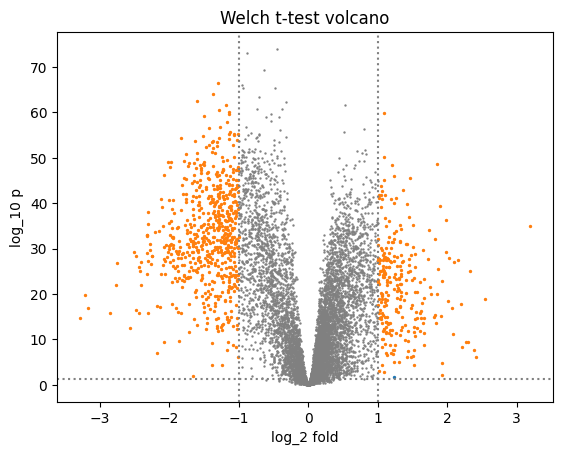

In [12]:
# Using volcano plot to select feature.
vol = Volcano_selection(strategy = "p", log_domain=False, absolute= False)
vol_importance = vol.Select(
    x_copy, y, -1)  # The number of features to select, and -1 means choose all.

# Plot the vlcano plot.
vol.plotting()

In [13]:
# Use several way to select features, which includes decision tree, random forest, lasso, multi lasso, svm, adaboost, xgboost
ensemble_selector = selector()
important_feature, importance = ensemble_selector.Select(x, y, 100)

Using  c45  to select.


100%|██████████| 9028/9028 [00:20<00:00, 440.96it/s]


c45  is done.

Using  RF_gini  to select.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

RF_gini  is done.

Using  AdaBoost  to select.
I don't have a progress bar but I am running
AdaBoost  is done.

Using  Lasso_Bisection  to select.


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e-01, tolerance: 4.575e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objecti

Lasso_Bisection  is done.

Using  multi_Lasso  to select.


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e-01, tolerance: 4.575e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e-01, tolerance: 4.575e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pac

multi_Lasso  is done.

Using  SVM  to select.
SVM  is done.

Using  XGboost  to select.
XGboost  is done.

Using  Lightgbm  to select.
[LightGBM] [Info] Number of positive: 103, number of negative: 80
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 561429
[LightGBM] [Info] Number of data points in the train set: 183, number of used features: 9028
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [14]:
# The features that was selected by ML algoritms.
important_feature

,DT_score_c45,RandomForest_gini,AdaBoost128,LassoLinear,multi_Lasso,SVM,XGboost,Lightgbm
0,DPP9,SUOX,EBNA1BP2,COL18A1,COX6B1,UMOD,WWC3,PFKP
1,IPO9,PWP1,NaN,FBLN5,HADH,HBD,TBXAS1,P4HA2
2,TRADD,TRADD,NaN,HADH,F9,TNC,P4HA2,BNIP3
3,DOCK4,PDK1,NaN,COL14A1,NDUFA4,BGN,TRADD,ITGAL
4,PFKP,DOCK4,NaN,FHL2,LDHB,PGK1,NUDCD3,NDUFA2
...,...,...,...,...,...,...,...,...
95,IGFBP3,GYS1,NaN,AHNAK,COL18A1,GGH,NaN,PSAP
96,HM13,NMI,NaN,HPX,TAGLN,HSPA9,NaN,IVNS1ABP
97,ERGIC3,NUDCD3,NaN,CBR1,CLU,ENO2,NaN,IGKV3-7
98,SEC24A,NDUFA2,NaN,ENO1,TNC,ACAT1,NaN,BLVRB


In [15]:
# The feature importance given by diffirent methods.
# Please Notice that the score between diffirent methods is not comparable.
importance

,DT_score_c45,RandomForest_gini,AdaBoost128,LassoLinear,multi_Lasso,SVM,XGboost,Lightgbm
DPP9,0.502841,0.007212,NaN,NaN,NaN,NaN,NaN,NaN
IPO9,0.502841,0.007658,NaN,NaN,NaN,NaN,NaN,NaN
TRADD,0.502841,0.008571,NaN,NaN,NaN,NaN,0.067873,3.0
DOCK4,0.502841,0.007838,NaN,NaN,NaN,NaN,NaN,NaN
PFKP,0.502304,0.005158,NaN,NaN,0.016103,0.002999,NaN,16.0
...,...,...,...,...,...,...,...,...
FN3K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
PSAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
IVNS1ABP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
IGKV3-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


# Analysis utils

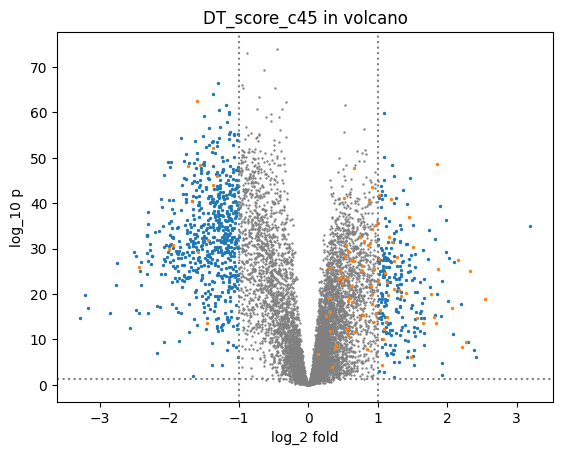

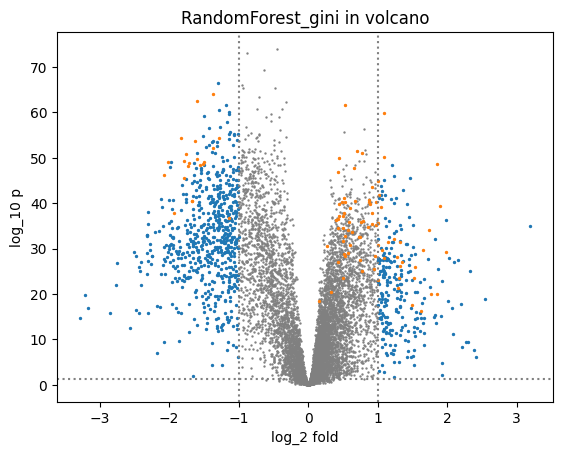

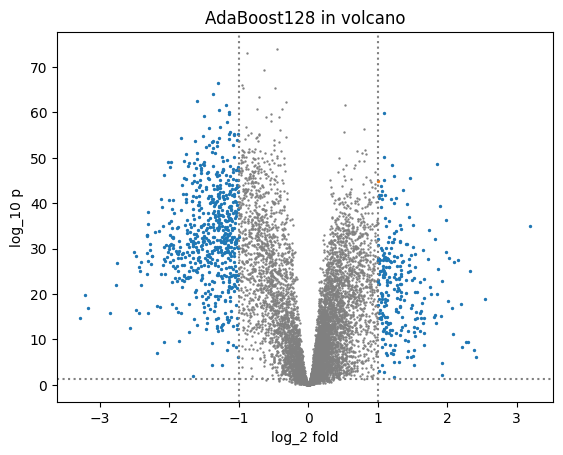

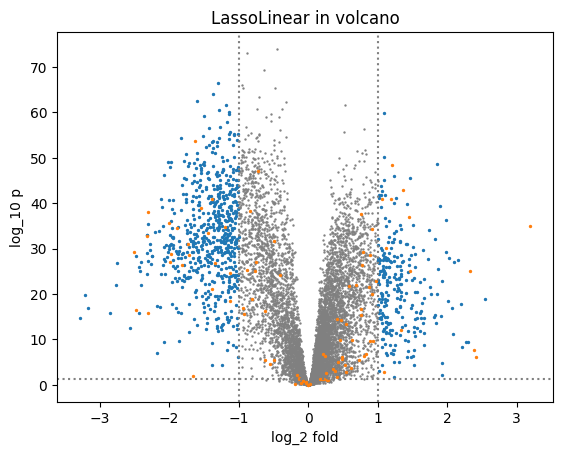

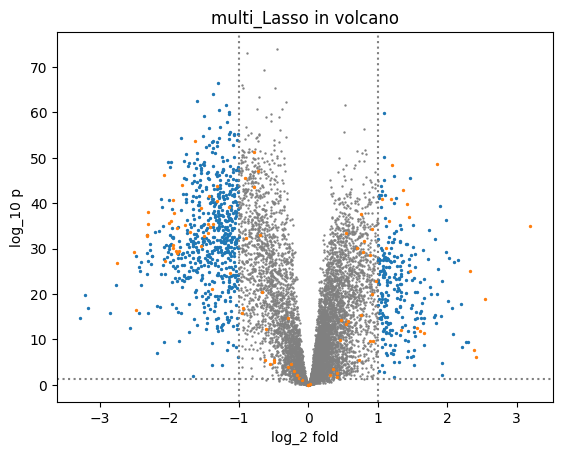

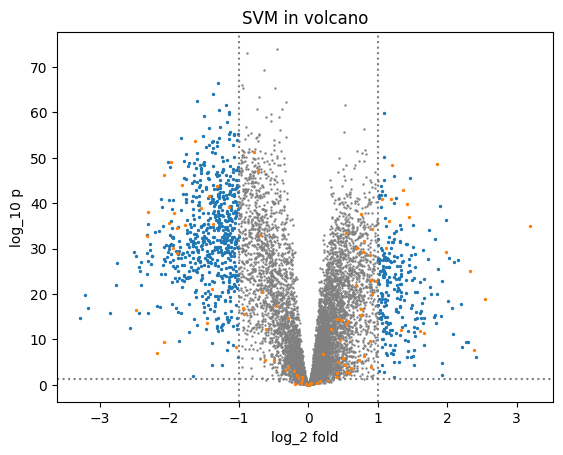

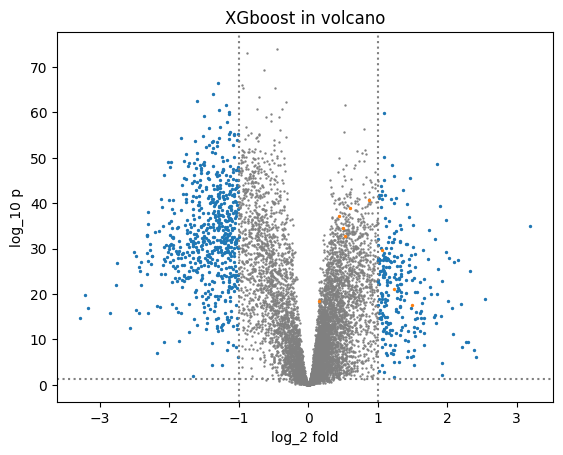

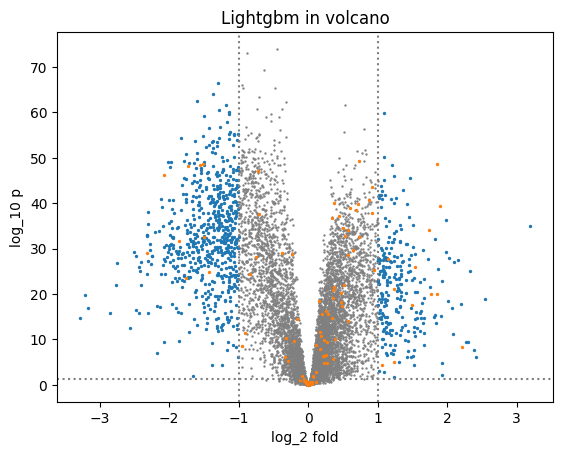

In [16]:
### Plot important features from diffirent methods on volcano plot.
for method in importance:
    vol.plotting(external=True,
                 external_score=importance[method].dropna(),
                 title=method + " in volcano",
                 show=False,
                 saving=True,
                 save_path="./output/images/" + export_title)

In [17]:
# Using g:profiler to do gene enrichment.
gp_enrichment_result = []
for method in important_feature.columns:
    gp_result = gp.profile(query = important_feature[method].dropna().to_list()).sort_values("p_value")
    gp_result["method"] = method
    gp_enrichment_result.append(gp_result[["method", "source", "native", "parents", "p_value", "description", "intersection_size"]])
gp_enrichment_result = pd.concat(gp_enrichment_result,
                                 axis=0).reset_index(drop=True)
# The result
gp_enrichment_result

C:\Users\aimhi\AppData\Local\Temp\ipykernel_14476\189993588.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gp_enrichment_result = pd.concat(gp_enrichment_result,


,method,source,native,parents,p_value,description,intersection_size
0,DT_score_c45,GO:BP,GO:0044281,[GO:0008152],4.707080e-13,"""The chemical reactions and pathways involving...",38
1,DT_score_c45,GO:CC,GO:0005737,"[GO:0005622, GO:0110165]",2.607657e-11,"""The contents of a cell excluding the plasma m...",90
2,DT_score_c45,GO:CC,GO:0005829,"[GO:0005737, GO:0110165]",1.105010e-10,"""The part of the cytoplasm that does not conta...",59
3,DT_score_c45,GO:BP,GO:0055086,"[GO:0006139, GO:0044281]",6.564838e-08,"""The cellular chemical reactions and pathways ...",20
4,DT_score_c45,GO:BP,GO:0009117,[GO:0006753],5.873435e-07,"""The chemical reactions and pathways involving...",18
...,...,...,...,...,...,...,...
1474,Lightgbm,KEGG,KEGG:01100,[KEGG:00000],3.779289e-02,Metabolic pathways,20
1475,Lightgbm,HPA,HPA:0470671,[HPA:0470000],3.845689e-02,skin 2; melanocytes[≥Low],15
1476,Lightgbm,TF,TF:M02036,[TF:M00000],3.872975e-02,Factor: WT1; motif: CGCCCCCNCN,70
1477,Lightgbm,TF,TF:M09894,[TF:M00000],3.913625e-02,Factor: E2F-4; motif: SNGGGCGGGAANN,95


In [18]:
# Showing the top 10 significant result
gp_enrichment_result.sort_values("p_value").head(20)

,method,source,native,parents,p_value,description,intersection_size
1081,SVM,GO:CC,GO:0070062,"[GO:0005615, GO:1903561]",1.879654e-57,"""A vesicle that is released into the extracell...",78
1082,SVM,GO:CC,GO:1903561,"[GO:0031982, GO:0065010]",4.499901e-57,"""Any vesicle that is part of the extracellular...",78
1084,SVM,GO:CC,GO:0043230,"[GO:0005576, GO:0043226]",4.665543e-57,"""Organized structure of distinctive morphology...",78
1083,SVM,GO:CC,GO:0065010,"[GO:0043227, GO:0043230]",4.665543e-57,"""Organized structure of distinctive morphology...",78
1085,SVM,GO:CC,GO:0005615,"[GO:0005576, GO:0110165]",6.073203e-51,"""That part of a multicellular organism outside...",84
671,multi_Lasso,GO:CC,GO:0070062,"[GO:0005615, GO:1903561]",2.818549e-47,"""A vesicle that is released into the extracell...",71
672,multi_Lasso,GO:CC,GO:1903561,"[GO:0031982, GO:0065010]",6.164908e-47,"""Any vesicle that is part of the extracellular...",71
674,multi_Lasso,GO:CC,GO:0065010,"[GO:0043227, GO:0043230]",6.367963e-47,"""Organized structure of distinctive morphology...",71
673,multi_Lasso,GO:CC,GO:0043230,"[GO:0005576, GO:0043226]",6.367963e-47,"""Organized structure of distinctive morphology...",71
358,LassoLinear,GO:CC,GO:0070062,"[GO:0005615, GO:1903561]",6.726840e-47,"""A vesicle that is released into the extracell...",70


# Modeling

In [19]:
from sklearn.model_selection import cross_val_score
from PineBioML.model.supervised.Classification import SVC_tuner

In [20]:
x = x.T
x = (x - x.mean()) / x.std()
x = x.T
#x = x / x.values.std()

svm_performance = []
for k in [5, 10, 20]:
    performance = {}
    for method in important_feature.columns:
        top_k = important_feature.head(k)[method].dropna()
        
        best_svc = SVC_tuner(x[top_k], y).tune()
        performance[method] = cross_val_score(best_svc, x[top_k], y, n_jobs=-1, cv=5, scoring = "roc_auc")
    svm_performance.append(pd.Series(performance, name="top" + str(k)))

#The result
svm_performance = pd.concat(svm_performance, axis=1)
svm_performance

[I 2024-07-02 02:00:02,999] A new study created in memory with name: no-name-a21f066b-7099-4369-827e-7bd70afa30fd
[I 2024-07-02 02:00:05,157] Trial 0 finished with value: 0.5183183183183184 and parameters: {'svc_c': 8.597564010091763e-05}. Best is trial 0 with value: 0.5183183183183184.
[I 2024-07-02 02:00:06,075] Trial 1 finished with value: 0.4816816816816817 and parameters: {'svc_c': 0.000461477638856965}. Best is trial 0 with value: 0.5183183183183184.
[I 2024-07-02 02:00:06,099] Trial 2 finished with value: 0.9945945945945945 and parameters: {'svc_c': 1.6839274558938793}. Best is trial 2 with value: 0.9945945945945945.
[I 2024-07-02 02:00:06,125] Trial 3 finished with value: 0.5627627627627627 and parameters: {'svc_c': 4.389041220290012e-05}. Best is trial 2 with value: 0.9945945945945945.
[I 2024-07-02 02:00:06,147] Trial 4 finished with value: 0.9837837837837838 and parameters: {'svc_c': 0.05385206753680649}. Best is trial 2 with value: 0.9945945945945945.
[I 2024-07-02 02:00:06

,top5,top10,top20
DT_score_c45,"[1.0, 1.0, 1.0, 0.9781249999999999, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
RandomForest_gini,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
AdaBoost128,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
LassoLinear,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
multi_Lasso,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
SVM,"[1.0, 1.0, 0.9910714285714286, 0.984375, 0.9875]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
XGboost,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
Lightgbm,"[1.0, 1.0, 1.0, 0.975, 1.0]","[1.0, 1.0, 1.0, 0.9781249999999999, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"


# Output

In [21]:
# Save the result ro output_path
important_feature.to_csv(output_folder + export_title + " important feature.csv")
importance.to_csv(output_folder+export_title+ " importance.csv")
gp_enrichment_result.to_csv(output_folder+export_title+ " g_prophiler.csv")
svm_performance.to_csv(output_folder+export_title+ " rbfSVM_performance.csv")
vol_importance.to_csv(output_folder + export_title + " volcano_foldchange.csv")